# setup

In [ ]:
import os
if not os.path.exists("econometrics-portfolio"):
    !git clone https://github.com/suha2502/econometrics-portfolio.git
%cd econometrics-portfolio/01-climate-mitigation-denim
!pip install -r packages.txt

In [ ]:
os.makedirs("data/derived", exist_ok=True)
os.makedirs("results", exist_ok=True)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.colors import to_hex
import seaborn as sns
import statsmodels.formula.api as smf
from statsmodels.tools.tools import add_constant
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_white
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [ ]:
mpl.rcParams.update({
    "text.usetex": False,
    "font.family": "serif",
    "font.serif": ["Computer Modern", "DejaVu Serif"],
    "axes.unicode_minus": False})

# data processing + cleaning

In [ ]:
# loading + merging individual WITS datafiles
folder_path = "data/raw"
column_selection = ["Product Description", "Year", "Partner", "Trade Value 1000USD", "Quantity", "Quantity Unit"]
data = []
for year in range(2000, 2024):
    file_path = f"{folder_path}/WITS_{year}.xlsx"
    if not os.path.exists(file_path):
        print(f"File {file_path} not found, skipped.")
        continue
    try:
        df = pd.read_excel(file_path, dtype=str)
        if all(col in df.columns for col in column_selection):
            df_selection = df.iloc[[0]][column_selection]
            data.append(df_selection)
        else:
            print(f"Columns missing in {file_path}, file skipped.")
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
df_merged = pd.concat(data, ignore_index=True)
output_path = "data/derived/WITS_merged.csv"
df_merged.to_csv(output_path, index=False)

File /workspaces/eco481-course-materials-suha2502/notes-submissions/data/raw/WITS_2017.xlsx not found, skipped.


In [ ]:
df = pd.read_csv('data/derived/WITS_merged.csv')
print("Columns:", df.columns)

Columns: Index(['Product Description', 'Year', 'Partner', 'Trade Value 1000USD',
       'Quantity', 'Quantity Unit'],
      dtype='object')


In [ ]:
# constructing jeans-level price, quantity, emissions, and water use variables
df = df.drop(columns=['Product Description', 'Partner', 'Quantity Unit'])
df = df.rename(columns={
    'Trade Value 1000USD': 'Imported Denim Value (US$)',
    'Quantity': 'Imported Denim Volume (kg)'})
df['Imported Denim Value (US$)'] = (df['Imported Denim Value (US$)'].astype(float) * 1000).round()
df = df.apply(lambda x: x.str.strip() if x.dtype == "object" else x)
df['Year'] = df['Year'].astype(int)
df['Imported Denim Value (US$)'] = df['Imported Denim Value (US$)'].astype(float)
df['Imported Denim Volume (kg)'] = df['Imported Denim Volume (kg)'].astype(float)
df['Quantity of Jeans (pairs)'] = df['Imported Denim Volume (kg)'] / 0.34019
df['Quantity of Jeans (pairs)'] = df['Quantity of Jeans (pairs)'].round()
df['GHG Emissions (kg CO2-eq)'] = df['Quantity of Jeans (pairs)'] * 33.4
df['GHG Emissions (kg CO2-eq)'] = df['GHG Emissions (kg CO2-eq)'].round(1)
df['Water Consumption (litres)'] = df['Quantity of Jeans (pairs)'] * 3781
df['Water Consumption (litres)'] = df['Water Consumption (litres)'].round(1)
df['Average Price of Jeans (US$/pair)'] = df['Imported Denim Value (US$)'] / df['Quantity of Jeans (pairs)']
df['Nominal Price of Jeans (US$/pair)'] = df['Average Price of Jeans (US$/pair)'].round(1)
df.to_csv('data/derived/WITS_merged_cleaned.csv', index=False)

In [ ]:
print(df_merged.columns)

Index(['Product Description', 'Year', 'Partner', 'Trade Value 1000USD',
       'Quantity', 'Quantity Unit'],
      dtype='object')


In [ ]:
df_cpi = pd.read_csv('data/raw/StatCan_CPI.csv')
df = pd.read_csv('data/derived/WITS_merged_cleaned.csv')
df_merged = pd.merge(df, df_cpi, on='Year', how='left')

In [ ]:
# re-indexing nominal prices from 2002 to 2022 -> enabling 2022 vs. 2023 comparison
base_2022 = df_cpi[df_cpi['Year'] == 2022]['CPI Clothing Index'].values[0]
df_merged['Real Price of Jeans (US$/pair)'] = df_merged['Nominal Price of Jeans (US$/pair)'] * (base_2022 / df_merged['CPI Clothing Index'])
df_merged.to_csv('data/derived/WITS_merged_cleaned.csv', index=False)
print(df_merged[['Year', 'Real Price of Jeans (US$/pair)', 'CPI Clothing Index']].head())

   Year  Real Price of Jeans (US$/pair)  CPI Clothing Index
0  2000                        1.544807               101.1
1  2001                        1.460612               101.3
2  2002                        1.890600               100.0
3  2003                        1.691358                97.2
4  2004                        1.785109                96.7


# descriptive analysis

In [ ]:
df = pd.read_csv('data/derived/WITS_merged_cleaned.csv')

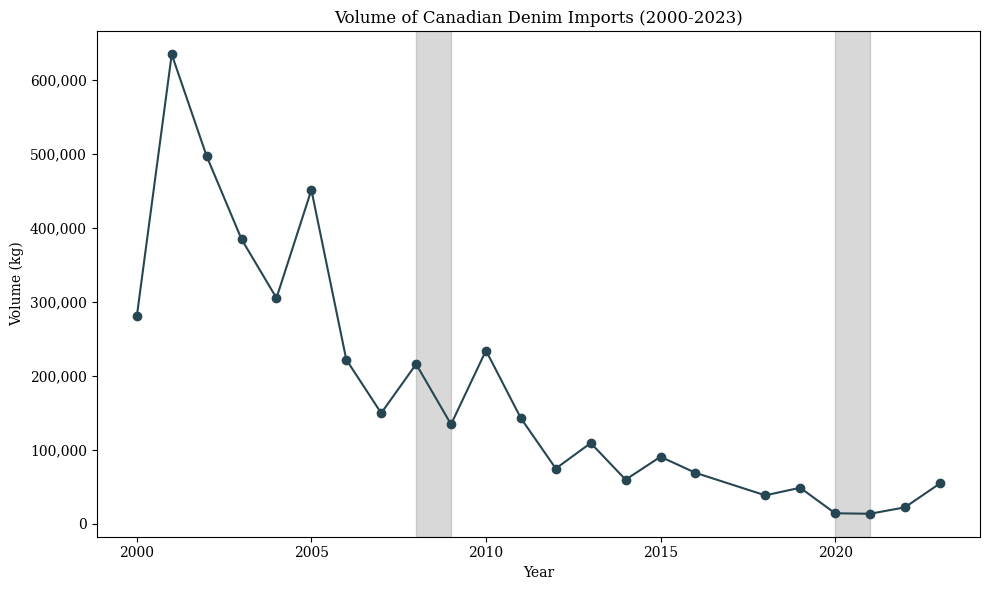

In [ ]:
# visualizing change in volume of demim imports over time
plt.figure(figsize=(10, 6))
plt.plot(df['Year'], df['Imported Denim Volume (kg)'], color='#264653', marker='o')
plt.xlabel('Year')
plt.ylabel('Volume (kg)')
plt.title('Volume of Canadian Denim Imports (2000-2023)')
plt.axvspan(2008, 2009, color='grey', alpha=0.3)
plt.axvspan(2020, 2021, color='grey', alpha=0.3)
ax = plt.gca()
ax.ticklabel_format(style='plain', axis='y')
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:,.0f}'))
plt.tight_layout()
plt.grid(False)
plt.savefig('results/volume_line.png', format='png')
plt.show()

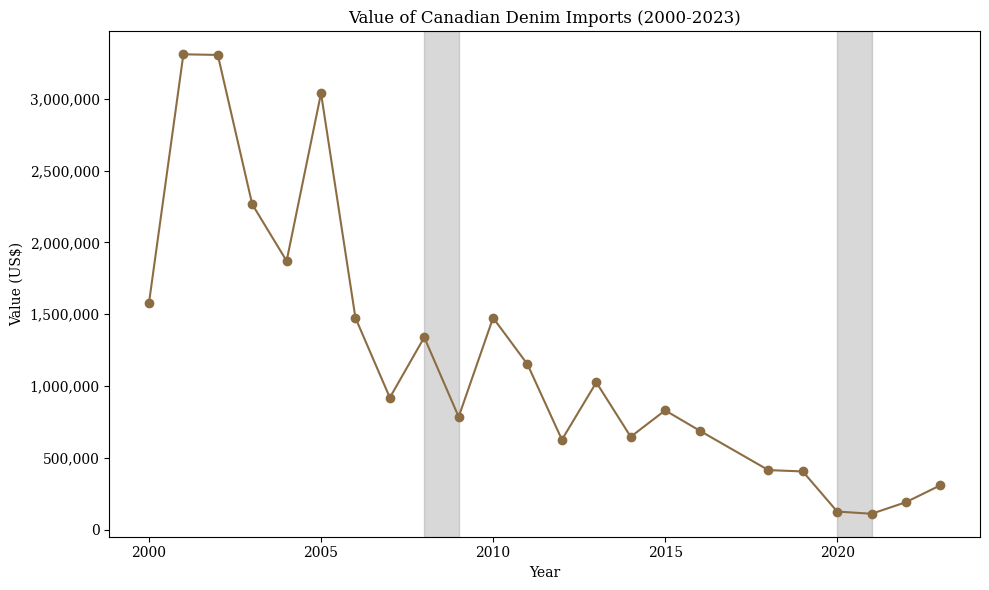

In [ ]:
# visualizing change in value of denim imports over time 
plt.figure(figsize=(10, 6))
plt.plot(df['Year'], df['Imported Denim Value (US$)'], color='#8c6d43', marker='o')
plt.xlabel('Year')
plt.ylabel('Value (US$)')
plt.title('Value of Canadian Denim Imports (2000-2023)')
ax = plt.gca()
ax.ticklabel_format(style='plain', axis='y')
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:,.0f}'))
plt.axvspan(2008, 2009, color='grey', alpha=0.3)
plt.axvspan(2020, 2021, color='grey', alpha=0.3)
plt.tight_layout()
plt.grid(False)
plt.savefig('results/value_line.png', format='png')
plt.show()

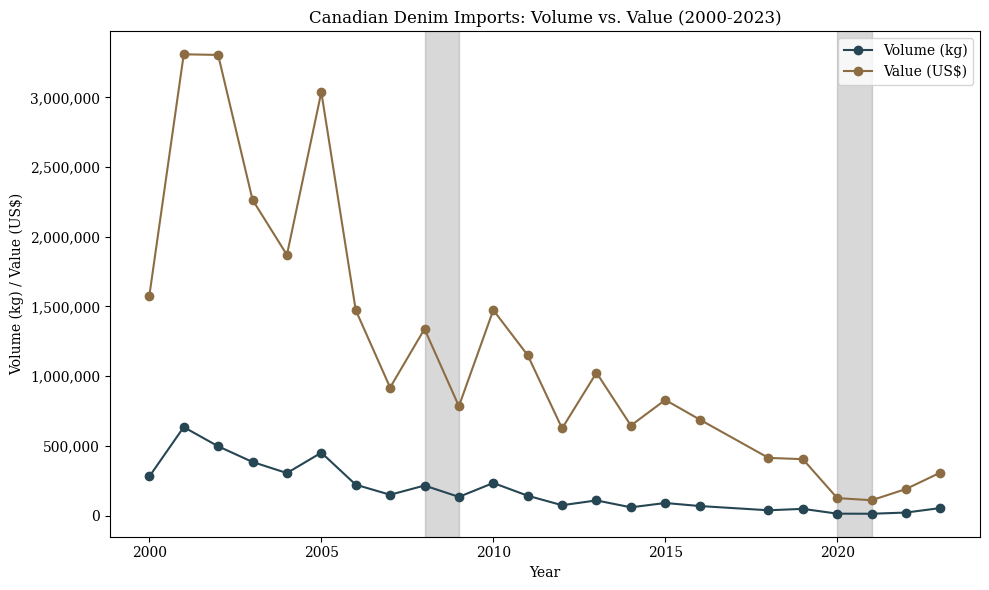

In [ ]:
# visualizing relationship between denim import volumes vs. values over time
plt.figure(figsize=(10, 6))
plt.plot(df['Year'], df['Imported Denim Volume (kg)'], label='Volume (kg)', color='#264653', marker='o')
plt.plot(df['Year'], df['Imported Denim Value (US$)'], label='Value (US$)', color='#8c6d43', marker='o')
plt.xlabel('Year')
plt.ylabel('Volume (kg) / Value (US$)')
plt.title('Canadian Denim Imports: Volume vs. Value (2000-2023)')
plt.legend()
ax = plt.gca()
ax.ticklabel_format(style='plain', axis='y')
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:,.0f}'))
plt.axvspan(2008, 2009, color='grey', alpha=0.3)
plt.axvspan(2020, 2021, color='grey', alpha=0.3)
plt.legend(loc='upper right')
plt.tight_layout()
plt.grid(False)
plt.savefig('results/denim_line.png', format='png')
plt.show()

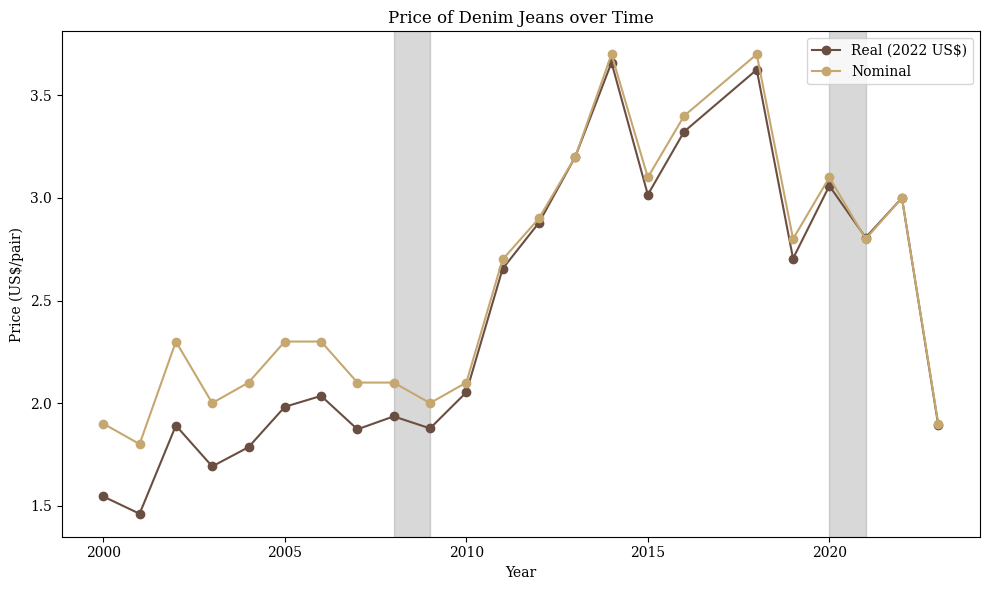

In [ ]:
# visualizing inflationary effects over time
plt.figure(figsize=(10, 6))
plt.plot(df['Year'], df['Real Price of Jeans (US$/pair)'], label='Real (2022 US$)', color='#6a4e42', marker='o')
plt.plot(df['Year'], df['Nominal Price of Jeans (US$/pair)'], label='Nominal', color='#c6a770', marker='o')
plt.xlabel('Year')
plt.ylabel('Price (US$/pair)')
plt.title('Price of Denim Jeans (2000-2023)')
plt.axvspan(2008, 2009, color='grey', alpha=0.3)
plt.axvspan(2020, 2021, color='grey', alpha=0.3)
plt.legend(loc='upper right')
plt.tight_layout()
plt.grid(False)
plt.savefig('results/inflation_line.png', format='png')
plt.show()

/tmp/ipykernel_595/1669509398.py:8: UserWarning: The palette list has more values (23) than needed (22), which may not be intended.
  sns.scatterplot(data=df.dropna(), x="YoY_RealPrice_Change (%)", y="YoY_Quantity_Change (%)", hue="Year", palette=mini_melts, s=80)


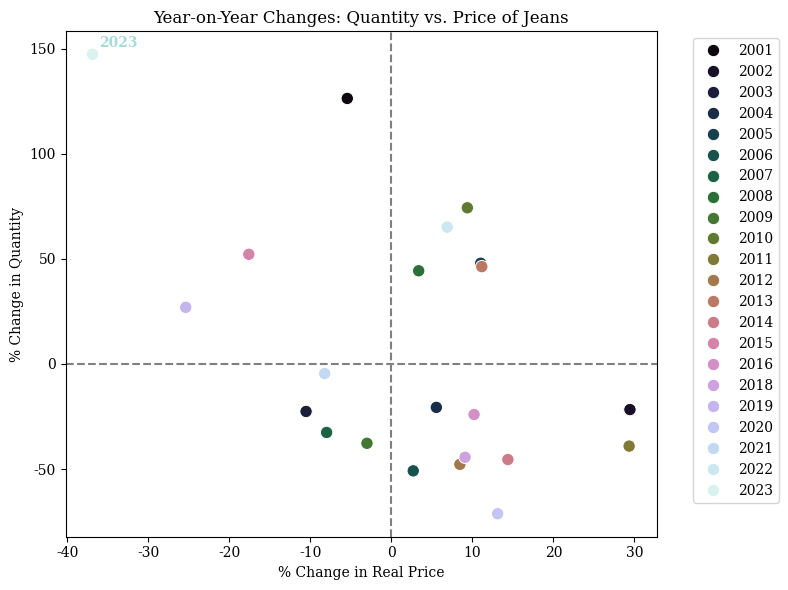

In [ ]:
# visualizing year-on-year changes in real prices and quantities -> deciding baseline vs. shock year
mini_melts = sns.color_palette("cubehelix", n_colors=df["Year"].nunique())
mini_melts = [to_hex(c) for c in mini_melts]
df = df.sort_values("Year").reset_index(drop=True)
df["YoY_Quantity_Change (%)"] = df["Quantity of Jeans (pairs)"].pct_change() * 100
df["YoY_RealPrice_Change (%)"] = df["Real Price of Jeans (US$/pair)"].pct_change() * 100
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df.dropna(), x="YoY_RealPrice_Change (%)", y="YoY_Quantity_Change (%)", hue="Year", palette=mini_melts, s=80)
plt.annotate("2023", 
             (df.loc[df["Year"] == 2023, "YoY_RealPrice_Change (%)"].values[0],
              df.loc[df["Year"] == 2023, "YoY_Quantity_Change (%)"].values[0]),
             textcoords="offset points", xytext=(5, 5), ha='left', fontsize=10, color='#a8dadc', fontweight='bold')
plt.axhline(0, linestyle="--", color="gray")
plt.axvline(0, linestyle="--", color="gray")
plt.title("Year-on-Year Changes: Quantity vs. Price of Jeans")
plt.xlabel("% Change in Real Price")
plt.ylabel("% Change in Quantity")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(False)
plt.tight_layout()
plt.savefig('results/time_scatter.png', format='png')
plt.show()

# logarithmic transformation

In [ ]:
# identifying best model fit to data
df['log_p'] = np.log(df['Real Price of Jeans (US$/pair)'])
df['log_q'] = np.log(df['Quantity of Jeans (pairs)'])
df.to_csv('data/derived/WITS_merged_cleaned.csv', index=False)

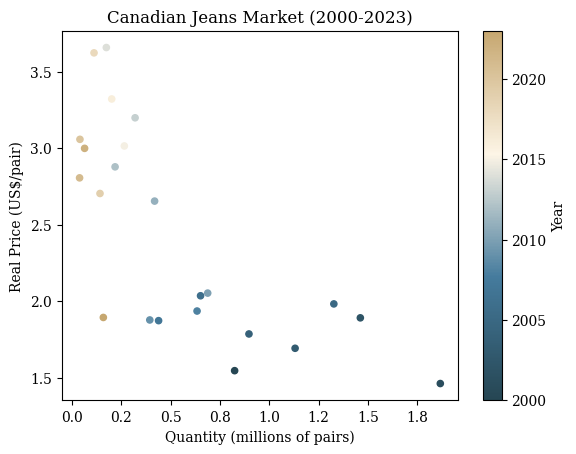

In [ ]:
jeans_ombre = LinearSegmentedColormap.from_list('jeans_ombre', ['#264653', '#457b9d', '#fdf5e6', '#c6a770'])
df.plot.scatter(x="Quantity of Jeans (pairs)", y="Real Price of Jeans (US$/pair)", xlabel="Quantity (pairs)", ylabel="Real Price (US$/pair)", title="Canadian Jeans Market (2000-2023)", c="Year", colormap=jeans_ombre)
ax = plt.gca()
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{x * 1e-6:.1f}'))
ax.set_xlabel("Quantity (millions of pairs)")
plt.grid(False)
plt.savefig('results/p_q_scatter.png', format='png')
plt.show()

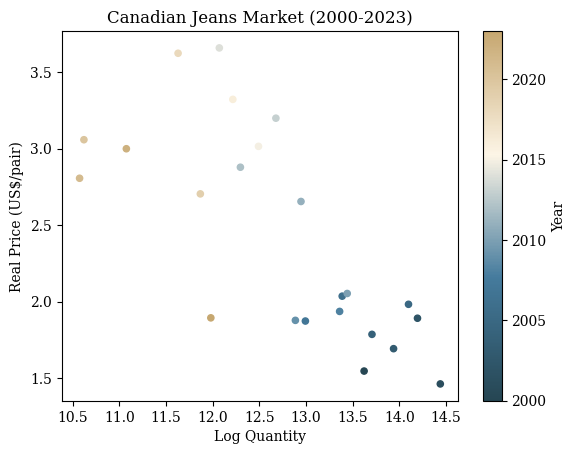

In [ ]:
df.plot.scatter(x="log_q", y="Real Price of Jeans (US$/pair)", xlabel="Log Quantity", ylabel="Real Price (US$/pair)", title="Canadian Jeans Market (2000-2023)", c="Year", colormap=jeans_ombre)
plt.grid(False)
plt.show()

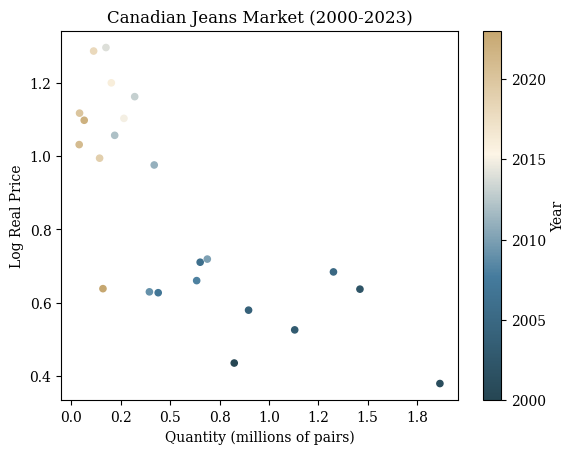

In [ ]:
df.plot.scatter(x="Quantity of Jeans (pairs)", y="log_p", xlabel="Quantity (pairs)", ylabel="Log Real Price", title="Canadian Jeans Market (2000-2023)", c="Year", colormap=jeans_ombre)
ax = plt.gca()
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{x * 1e-6:.1f}'))
ax.set_xlabel("Quantity (millions of pairs)")
plt.grid(False)
plt.show()

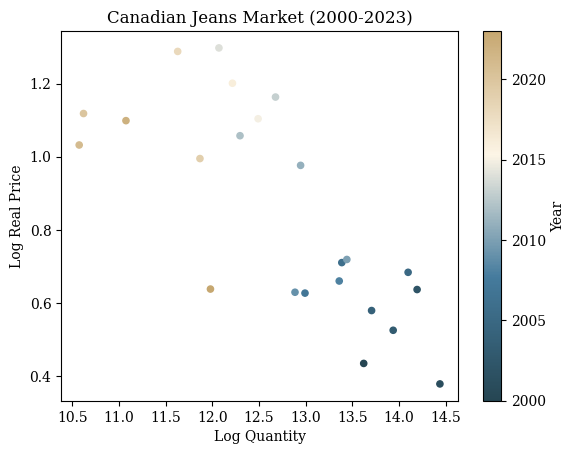

In [ ]:
df.plot.scatter(x="log_q", y="log_p", xlabel="Log Quantity", ylabel="Log Real Price", title="Canadian Jeans Market (2000-2023)", c="Year", colormap=jeans_ombre)
plt.grid(False)
plt.savefig('results/log_p_log_q_scatter.png', format='png')

# baseline regression

In [ ]:
res = smf.ols('log_q ~ log_p', data = df).fit()
with open("results/table_1.tex", "w") as f:
    f.write(res.summary().as_latex())
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  log_q   R-squared:                       0.563
Model:                            OLS   Adj. R-squared:                  0.542
Method:                 Least Squares   F-statistic:                     27.02
Date:                Fri, 09 May 2025   Prob (F-statistic):           3.76e-05
Time:                        00:00:28   Log-Likelihood:                -24.949
No. Observations:                  23   AIC:                             53.90
Df Residuals:                      21   BIC:                             56.17
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     15.1953      0.502     30.292      0.000      14.152      16.238
log_p         -2.9143      0.561     -5.198      0.000      -4.080      -1.748
==============================================================================
Omnibus:                        3.503   Durbin-Watson:                   0.538
Prob(Omnibus):                  0.173   Jarque-Bera (JB):                2.821
Skew:                          -0.844   Prob(JB):                        0.244
Kurtosis:                       2.697   Cond. No.                         6.30
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
res.params

Intercept    15.195285
log_p        -2.914297
dtype: float64

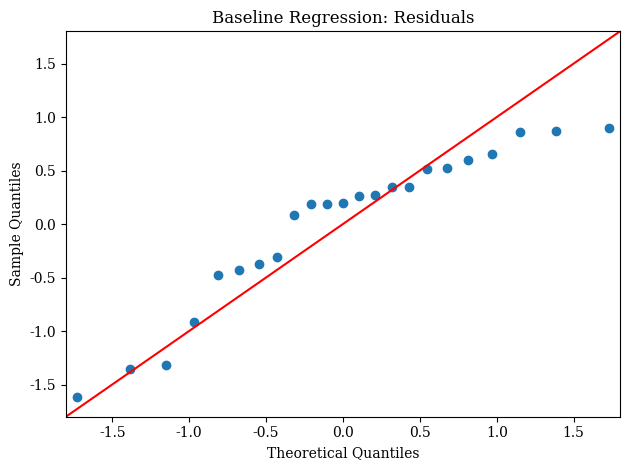

In [ ]:
# visually testing for OLS assumption of normal residuals using quantile-quantile plot -> hypothesis testing
residuals = res.resid
sm.qqplot(residuals, line='45')
plt.title("Baseline Regression: Residuals")
plt.tight_layout()
plt.grid(False)
plt.savefig("results/qq_baseline.png", dpi=300, bbox_inches='tight')
plt.show()

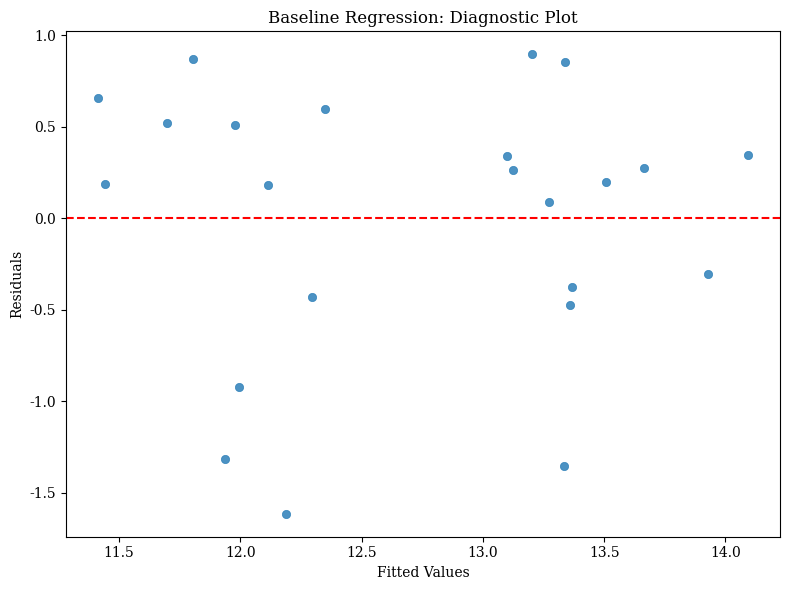

In [ ]:
# visually testing for OLS assumption of heteroscedasticity using diagnostic plot -> constant variance of residuals
fitted = res.fittedvalues
residuals = res.resid
plt.figure(figsize=(8, 6))
plt.scatter(fitted, residuals, linewidth=0.5, alpha=0.8)
plt.axhline(0, color='red', linestyle='--', linewidth=1.5)
plt.title("Baseline Regression: Diagnostic Plot")
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.grid(False)
plt.tight_layout()
plt.savefig("results/baseline_diagnostic.png", dpi=300)
plt.show()

In [ ]:
# statistically testing for OLS assumption of heteroscedasticity -> constant variance of residuals
white_test = het_white(res.resid, res.model.exog)
print('White test p-value:', white_test[1])

White test p-value: 0.30447814565184694


# first-differenced regression

In [ ]:
df['log_q_diff'] = df.log_q - df.log_q.shift()
df['log_p_diff'] = df.log_p - df.log_p.shift()
df_diff = df.dropna(subset=['log_q_diff', 'log_p_diff'])
res_diff = smf.ols('log_q_diff ~ log_p_diff', data = df_diff).fit()
with open("results/table_2.tex", "w") as f:
    f.write(res_diff.summary().as_latex())
res_diff.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             log_q_diff   R-squared:                       0.219
Model:                            OLS   Adj. R-squared:                  0.179
Method:                 Least Squares   F-statistic:                     5.594
Date:                Fri, 09 May 2025   Prob (F-statistic):             0.0282
Time:                        00:00:29   Log-Likelihood:                -15.382
No. Observations:                  22   AIC:                             34.76
Df Residuals:                      20   BIC:                             36.95
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0602      0.109     -0.552      0.587      -0.288       0.167
log_p_diff    -1.5683      0.663     -2.365      0.028      -2.951      -0.185
==============================================================================
Omnibus:                        1.074   Durbin-Watson:                   2.226
Prob(Omnibus):                  0.584   Jarque-Bera (JB):                0.801
Skew:                           0.060   Prob(JB):                        0.670
Kurtosis:                       2.073   Cond. No.                         6.09
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
res_diff.params

Intercept    -0.060199
log_p_diff   -1.568311
dtype: float64

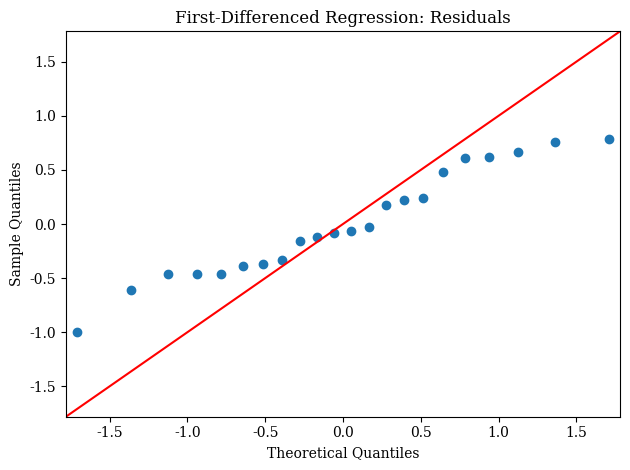

In [ ]:
# visually testing for OLS assumption of normal residuals using quantile-quantile plot -> hypothesis testing
residuals = res_diff.resid
sm.qqplot(residuals, line='45')
plt.title("First-Differenced Regression: Residuals")
plt.tight_layout()
plt.grid(False)
plt.savefig("results/qq_differenced.png", dpi=300, bbox_inches='tight')
plt.show()

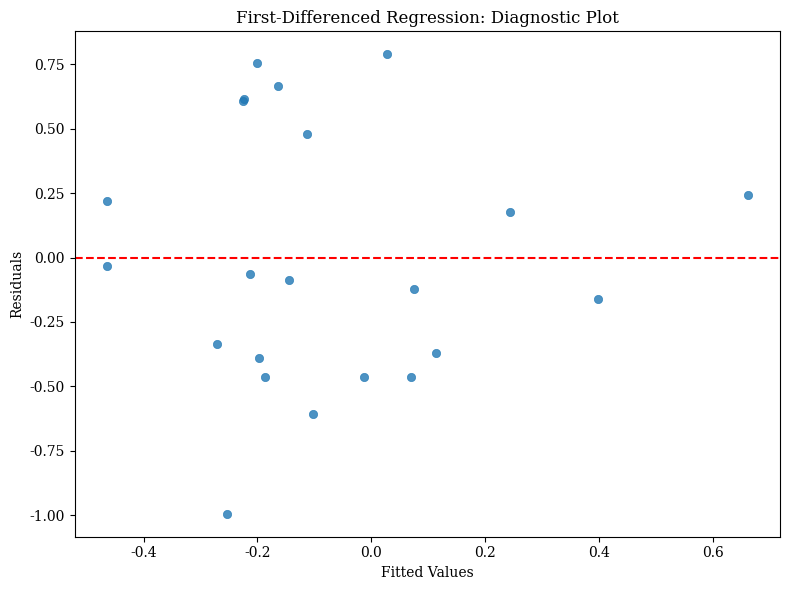

In [ ]:
# visually testing for OLS assumption of heteroscedasticity using diagnostic plot -> constant variance of residuals
fitted = res_diff.fittedvalues
residuals = res_diff.resid
plt.figure(figsize=(8, 6))
plt.scatter(fitted, residuals, linewidth=0.5, alpha=0.8)
plt.axhline(0, color='red', linestyle='--', linewidth=1.5)
plt.title("First-Differenced Regression: Diagnostic Plot")
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.tight_layout()
plt.grid(False)
plt.savefig("results/diff_diagnostic.png", dpi=300)
plt.show()

In [ ]:
# statistically testing for OLS assumption of heteroscedasticity -> constant variance of residuals
white_test = het_white(res_diff.resid, res_diff.model.exog)
print('White test p-value:', white_test[1])

White test p-value: 0.31093414503528716


# counterfactual analysis

In [ ]:
# comparing short-run changes between 2022 to 2023
wits = pd.read_csv("data/derived/WITS_merged_cleaned.csv")
year_2022 = wits[wits["Year"] == 2022].copy()
year_2023 = wits[wits["Year"] == 2023].copy()

# defining key tax shock(s)
tax_shocks = {'20% Pigouvian Tax': 0.20, '25% Tariff': 0.25}

# using first-differenced regression specification
elasticity = res_diff.params['log_p_diff']

# logic: q_predicted = q_baseline * (1 + t)^elasticity
q_baseline = year_2022["Quantity of Jeans (pairs)"].values[0]
p_baseline = year_2022["Real Price of Jeans (US$/pair)"].values[0]

In [ ]:
# storing counterfactual outcomes
results = []
for label, t in tax_shocks.items():
    q_predicted = q_baseline * (1 + t) ** elasticity
    q_percent_change = 100 * (q_predicted - q_baseline) / q_baseline
    results.append({
        'Scenario': label,
        'Shock (%)': t * 100,
        'Baseline Quantity (2022)': round(q_baseline),
        'Predicted Quantity (2023)': round(q_predicted),
        'Change in Quantity (%)': round(q_percent_change, 2)})
counterfactual = pd.DataFrame(results)

In [ ]:
# constructing environmental outcome variables tied to literature-derived benchmarks
emissions_per_pair = 33.4
water_per_pair = 3781
emissions_baseline = q_baseline * emissions_per_pair
water_baseline = q_baseline * water_per_pair

# estimating environmental savings using baseline vs. predicted demand change
for i, row in counterfactual.iterrows():
    q_baseline_row = row['Baseline Quantity (2022)']
    q_predicted_row = row['Predicted Quantity (2023)']
    q_diff = q_baseline_row - q_predicted_row
    emissions_predicted = q_predicted_row * emissions_per_pair
    water_predicted = q_predicted_row * water_per_pair
    counterfactual.loc[i, 'Predicted Emissions (2023)'] = round(emissions_predicted, 1)
    counterfactual.loc[i, 'Predicted Water (2023)'] = round(water_predicted, 1)
print(counterfactual)
counterfactual.to_csv("data/derived/counterfactual_results.csv", index=False)

            Scenario  Shock (%)  Baseline Quantity (2022)  \
0  20% Pigouvian Tax       20.0                     64443   
1         25% Tariff       25.0                     64443   

   Predicted Quantity (2023)  Change in Quantity (%)  \
0                      48417                  -24.87   
1                      45414                  -29.53   

   Predicted Emissions (2023)  Predicted Water (2023)  
0                   1617127.8             183064677.0  
1                   1516827.6             171710334.0  


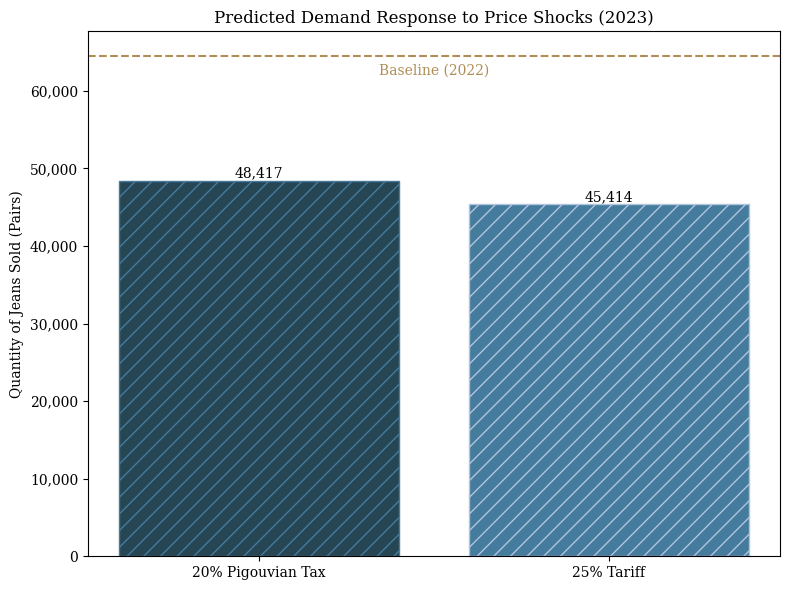

In [ ]:
# visualizing counterfactual demand response
plt.figure(figsize=(8, 6))
bars = plt.bar(counterfactual['Scenario'], counterfactual['Predicted Quantity (2023)'],
               color=['#264653', '#457b9d'], edgecolor=['#457b9d', '#b0c4de'], hatch='//')
plt.axhline(q_baseline, color='#b08d57', linestyle='--')
ymax = plt.ylim()[1]
plt.text(0.5, q_baseline - (ymax * 0.035), f'Baseline (2022)', 
         ha='center', color='#b08d57', fontsize=10)
plt.ylabel('Quantity of Jeans Sold (Pairs)')
plt.title('Predicted Demand Response to Price Shocks (2023)')
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{int(x):,}'))
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height,
             f'{int(height):,}', ha='center', va='bottom', fontsize=10)
plt.tight_layout()
plt.grid(False)
plt.savefig("results/results_quantity.png", dpi=300)
plt.show()

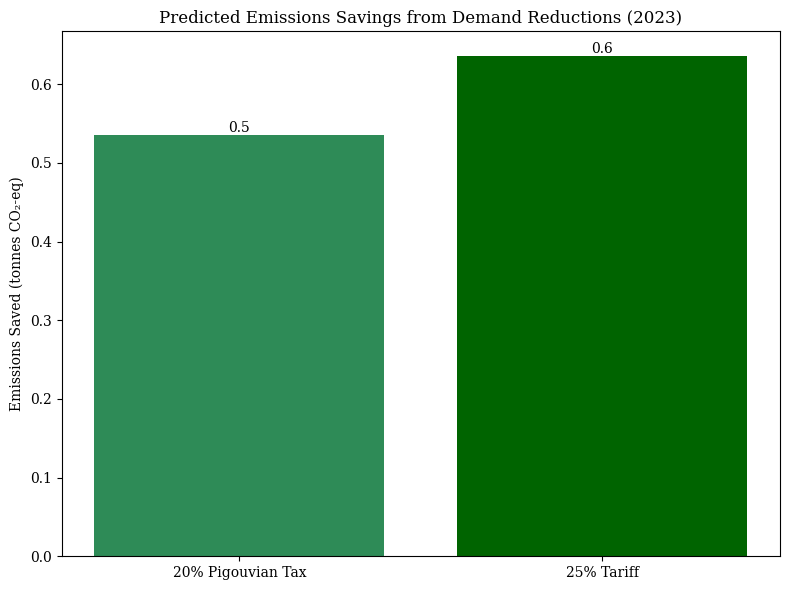

In [ ]:
# visualizing counterfactual emissions savings
scenarios = counterfactual['Scenario']
emissions = (emissions_baseline - counterfactual['Predicted Emissions (2023)']) / 1e6
fig, ax = plt.subplots(figsize=(8, 6))
x = range(len(scenarios))
bars = ax.bar(
    x, emissions,
    color=['#2e8b57', '#006400'],
    linewidth=1.5,)
ax.set_xticks(x)
ax.set_xticklabels(scenarios)
ax.set_ylabel('Emissions Saved (tonnes CO₂-eq)')
ax.set_title('Predicted Emissions Savings from Demand Reductions (2023)')
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{x:,.1f}'))
for bar in bars:
    yval = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2, yval,
        f'{yval:,.1f}', ha='center', va='bottom', fontsize=10)
plt.tight_layout()
plt.grid(False)
plt.savefig("results/results_emissions.png", dpi=300)
plt.show()

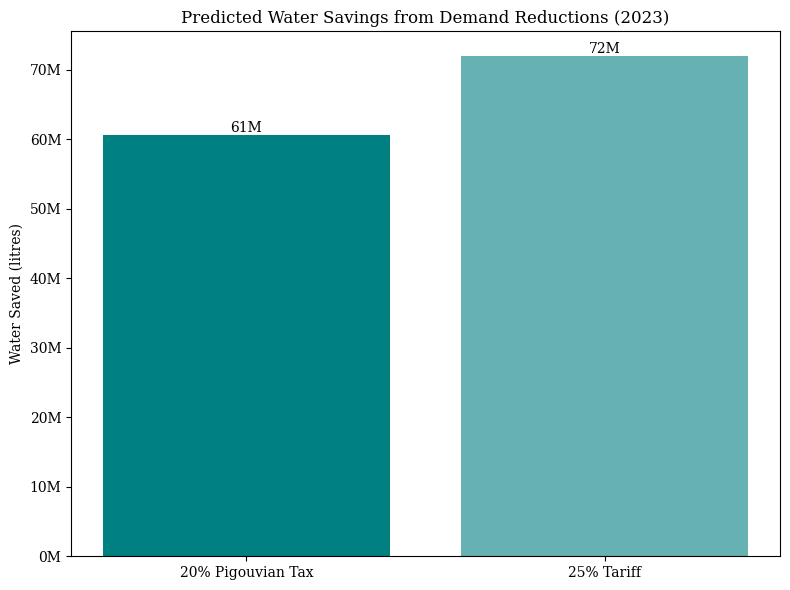

In [ ]:
# visualizing counterfactual water savings
scenarios = counterfactual['Scenario']
water = (water_baseline - counterfactual['Predicted Water (2023)']) / 1e6
fig, ax = plt.subplots(figsize=(8, 6))
bars = ax.bar(
    x, water,
    color=['#008080', '#66b2b2'],
    linewidth=1.5,)
ax.set_xticks(x)
ax.set_xticklabels(scenarios)
ax.set_ylabel('Water Saved (litres)')
ax.set_title('Predicted Water Savings from Demand Reductions (2023)')
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{int(x)}M'))
for bar in bars:
    yval = bar.get_height()
    ax.text(
    bar.get_x() + bar.get_width() / 2, yval,
    f'{yval:.0f}M', ha='center', va='bottom', fontsize=10)
plt.tight_layout()
plt.grid(False)
plt.savefig("results/results_water.png", dpi=300)
plt.show()

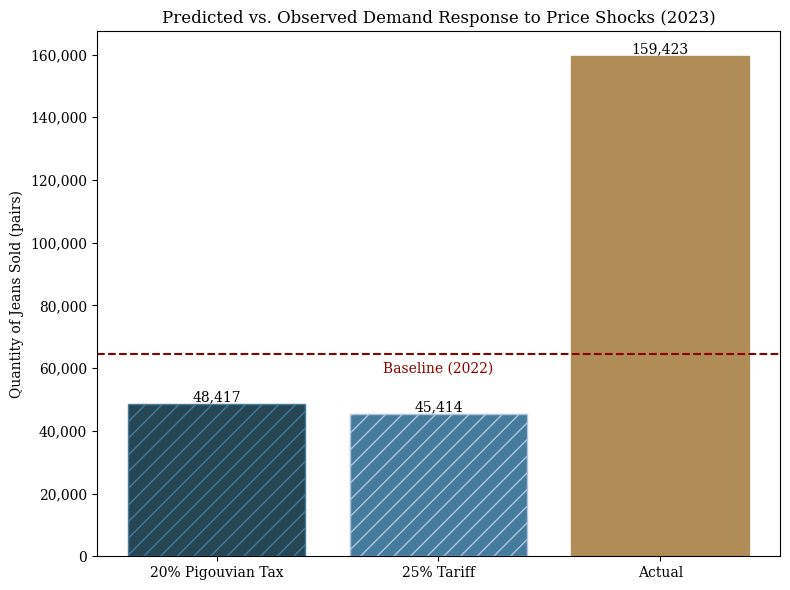

In [ ]:
# visualizing counterfactual vs. actual demand response
q_actual = year_2023["Quantity of Jeans (pairs)"].values[0]
counterfactual.loc[len(counterfactual)] = {
    'Scenario': 'Actual',
    'Shock (%)': np.nan,
    'Baseline Quantity (2022)': q_baseline,
    'Predicted Quantity (2023)': q_actual,
    'Change in Quantity (%)': np.nan,
    'Predicted Emissions (2023)': np.nan,
    'Predicted Water (2023)': np.nan}
plt.figure(figsize=(8, 6))
bars = plt.bar(
    counterfactual['Scenario'],
    counterfactual['Predicted Quantity (2023)'],
    color=['#264653', '#457b9d', '#8B0000'],
    edgecolor=['#457b9d', '#b0c4de', '#8B0000'],
    hatch=['//', '//', None])
plt.axhline(q_baseline, color='#b08d57', linestyle='--')
ymax = plt.ylim()[1]
plt.text(1, q_baseline - (ymax * 0.035), 'Baseline (2022)', 
         ha='center', color='#b08d57', fontsize=10)
plt.ylabel('Quantity of Jeans Sold (pairs)')
plt.title('Predicted vs. Observed Demand Response (2023)')
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{int(x):,}'))
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height,
             f'{int(height):,}', ha='center', va='bottom', fontsize=10)
plt.tight_layout()
plt.grid(False)
plt.savefig("results/results_quantity_actual.png", dpi=300)
plt.show()

# sensitivity analysis

In [ ]:
df = pd.read_csv("data/derived/WITS_merged_cleaned.csv")
df['log_q'] = np.log(df['Quantity of Jeans (pairs)'])
df['log_p'] = np.log(df['Real Price of Jeans (US$/pair)'])
df['log_q_diff'] = df['log_q'].diff()
df['log_p_diff'] = df['log_p'].diff()
df_diff = df.dropna(subset=['log_q_diff', 'log_p_diff']).copy()

In [ ]:
# calculating 95% C.I. for elasticity estimate
elasticity_lower = res_diff.params['log_p_diff'] - 1.96 * res_diff.bse['log_p_diff']
elasticity_upper = res_diff.params['log_p_diff'] + 1.96 * res_diff.bse['log_p_diff']
print(f"95% CI for Elasticity: [{elasticity_lower:.3f}, {elasticity_upper:.3f}]")

# testing elasticity bounds for estimation errors -> predicting quantities
def simulate_quantity(p_baseline, q_baseline, tax_shock, elasticity):
    p_shock = p_baseline * (1 + tax_shock)
    return q_baseline * (p_shock / p_baseline) ** elasticity
tax_shock = 0.20
q_predicted_lower = simulate_quantity(p_baseline, q_baseline, tax_shock, elasticity_lower)
q_predicted_upper = simulate_quantity(p_baseline, q_baseline, tax_shock, elasticity_upper)
print(f"\nPredicted Quantity (Lower Elasticity): {q_predicted_lower:,.0f}")
print(f"Predicted Quantity (Upper Elasticity): {q_predicted_upper:,.0f}")
print(f"\nPredicted Emissions (Lower Elasticity): {q_predicted_lower * emissions_per_pair:,.1f} kg")
print(f"Predicted Emissions (Upper Elasticity): {q_predicted_upper * emissions_per_pair:,.1f} kg")
print(f"Predicted Water Use (Lower Elasticity): {q_predicted_lower * water_per_pair:,.1f} litres")
print(f"Predicted Water Use (Upper Elasticity): {q_predicted_upper * water_per_pair:,.1f} litres")

95% CI for Elasticity: [-2.868, -0.269]

Predicted Quantity (Lower Elasticity): 38,202
Predicted Quantity (Upper Elasticity): 61,363

Predicted Emissions (Lower Elasticity): 1,275,948.2 kg
Predicted Emissions (Upper Elasticity): 2,049,508.9 kg
Predicted Water Use (Lower Elasticity): 144,441,924.0 litres
Predicted Water Use (Upper Elasticity): 232,011,770.6 litres


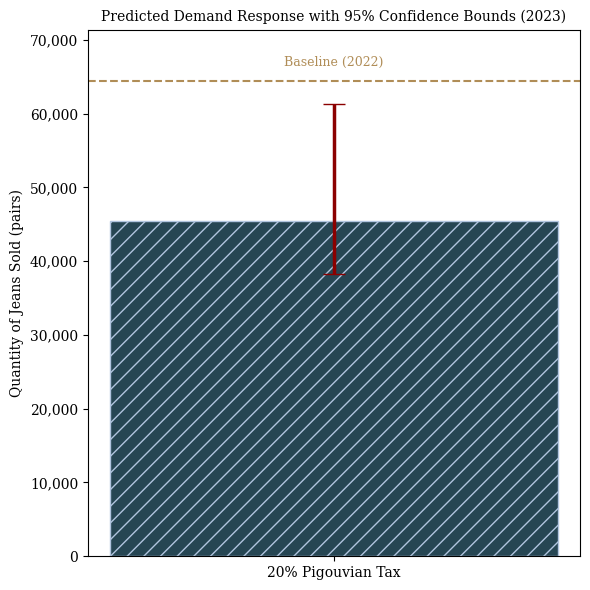

In [ ]:
# visualizing sensitivity to elasticity bounds
plt.figure(figsize=(6, 6))
bar = plt.bar(['20% Pigouvian Tax'], [q_predicted],
              color='#264653', edgecolor='#b0c4de', hatch='//', width=0.4)
plt.errorbar(['20% Pigouvian Tax'], [q_predicted],
             yerr=[[q_predicted - q_predicted_lower], [q_predicted_upper - q_predicted]],
             fmt='none', ecolor='#b08d57', capsize=8, linewidth=2.5)
plt.axhline(q_baseline, color='#8B0000', linestyle='--')
plt.text(0, q_baseline + 2000, 'Baseline (2022)', ha='center',
         color='#8B0000', fontsize=9)
plt.ylabel('Quantity of Jeans Sold (pairs)')
plt.title('Predicted Demand Response, with 95% Confidence Bounds (2023)', fontsize=10)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{int(x):,}'))
plt.ylim(0, q_predicted_upper + 10000)
plt.tight_layout()
plt.grid(False)
plt.savefig("results/sensitivity_bar.png", dpi=300)
plt.show()

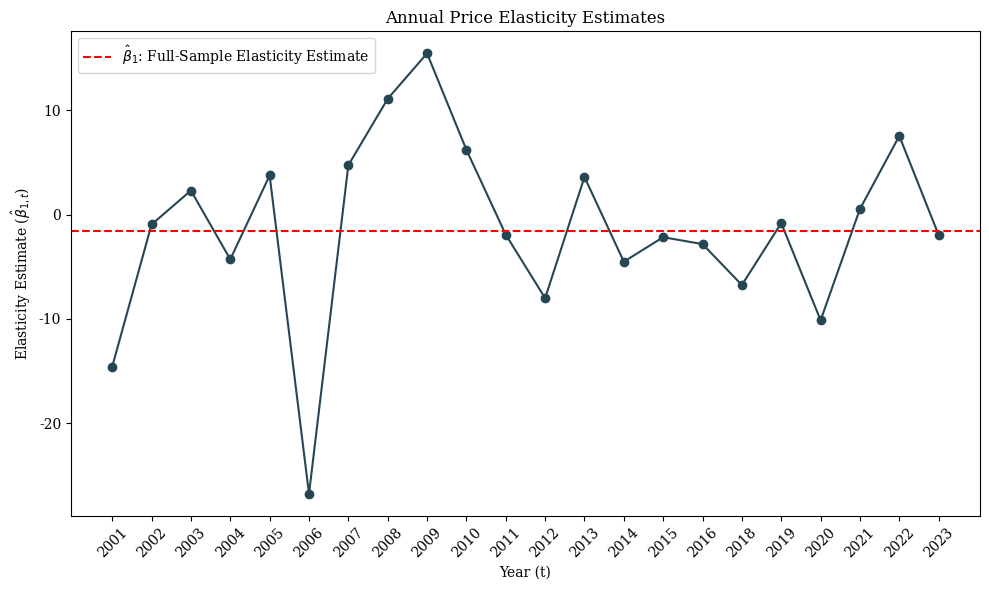

In [ ]:
# testing + visualizing year-wise elasticity -> constant-elasticity validity + temporal stability
df_diff['Elasticity'] = df_diff['log_q_diff'] / df_diff['log_p_diff']
plt.figure(figsize=(10, 6))
years = df_diff['Year'].astype(str)
plt.plot(years, df_diff['Elasticity'], marker='o', linestyle='-', color='#264653')
plt.axhline(y=elasticity, linestyle='--', color='red', label=r'$\hat{\beta}_1$: Full-Sample Elasticity Estimate')
plt.title('Annual Price Elasticity Estimates')
xticks = df_diff['Year'][::2]
plt.xticks(rotation=45, fontsize=10)
plt.xlabel('Year (t)')
plt.ylabel(r'Elasticity Estimate ($\hat{\beta}_{1,t}$)')
plt.legend(loc='upper left')
plt.grid(False)
plt.tight_layout()
plt.savefig("results/robustness_time.png", dpi=300)
plt.show()

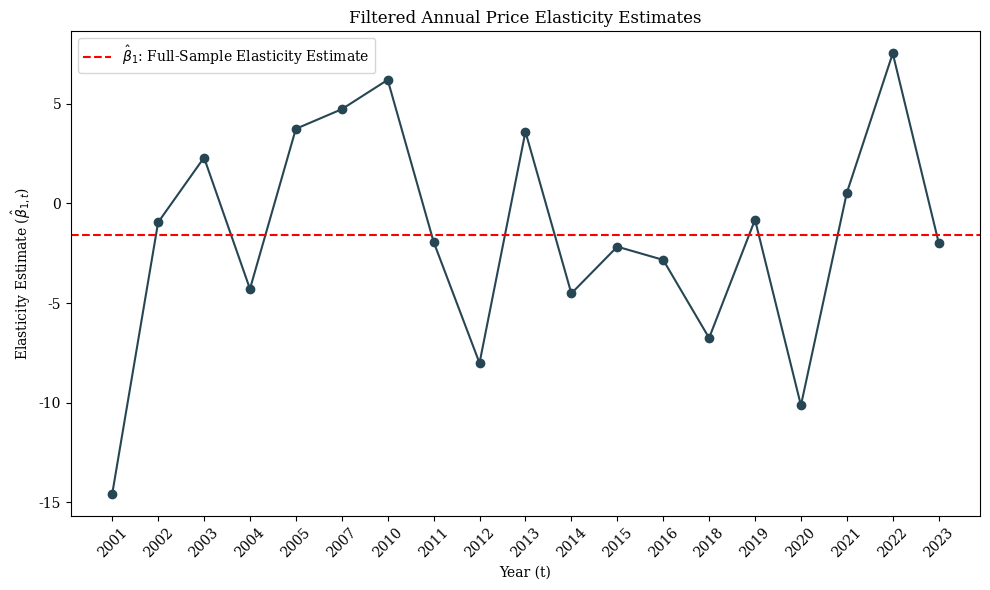

In [ ]:
# dropping year-pairs with small price changes (ΔlogP < 0.05)
df_filtered = df_diff[np.abs(df_diff['log_p_diff']) >= 0.05].copy()
df_filtered['Elasticity'] = df_filtered['log_q_diff'] / df_filtered['log_p_diff']

# testing + visualizing year-wise elasticity after filtering for outliers
plt.figure(figsize=(10, 6))
years = df_filtered['Year'].astype(str)
plt.plot(years, df_filtered['Elasticity'], marker='o', linestyle='-', color='#264653')
plt.axhline(y=elasticity, linestyle='--', color='red', label=r'$\hat{\beta}_1$: Full-Sample Elasticity Estimate')
plt.title("Filtered Annual Price Elasticity Estimates")
plt.xticks(rotation=45, fontsize=10)
plt.xlabel("Year (t)")
plt.ylabel(r'Elasticity Estimate ($\hat{\beta}_{1,t}$)')
plt.legend(loc='upper left')
plt.grid(False)
plt.tight_layout()
plt.savefig("results/robustness_time_filtered.png", dpi=300)
plt.show()

In [ ]:
# running placebo counterfactual as falsification test using most stable year-pair -> what would have happened in 2016 had a 20% tax been applied in 2015?
q_2015 = df[df["Year"] == 2015]["Quantity of Jeans (pairs)"].values[0]
p_2015 = df[df["Year"] == 2015]["Real Price of Jeans (US$/pair)"].values[0]
q_2016_actual = df[df["Year"] == 2016]["Quantity of Jeans (pairs)"].values[0]
q_2016_pred = q_2015 * (1 + 0.20) ** elasticity
emissions_pred = q_2016_pred * emissions_per_pair
water_pred = q_2016_pred * water_per_pair
emissions_actual = q_2016_actual * emissions_per_pair
water_actual = q_2016_actual * water_per_pair
q_diff = q_2016_pred - q_2016_actual
emissions_diff = emissions_pred - emissions_actual
water_diff = water_pred - water_actual
print("Placebo Counterfactual:\n")
print(f"Baseline Quantity (2015): {q_2015:,.0f}")
print(f"Actual Quantity (2016): {q_2016_actual:,.0f}")
print(f"Predicted Quantity (2016): {q_2016_pred:,.0f}")
print(f"Difference (Predicted - Actual): {q_diff:,.0f}\n")
print(f"Implied Emissions Gap (thousand kg CO2-eq): {emissions_diff / 1e3:.2f}")
print(f"Implied Water Gap (million litres): {water_diff / 1e6:.2f}")

Placebo Counterfactual:

Baseline Quantity (2015): 265,740
Actual Quantity (2016): 201,823
Predicted Quantity (2016): 199,653
Difference (Predicted - Actual): -2,170

Implied Emissions Gap (thousand kg CO2-eq): -72.47
Implied Water Gap (million litres): -8.20


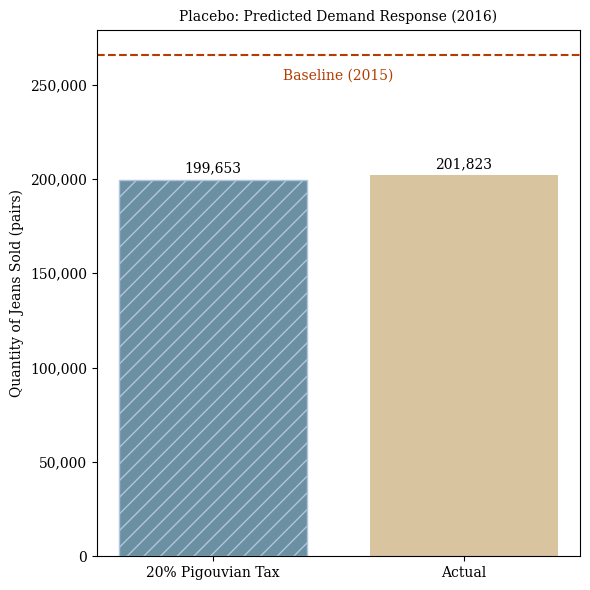

In [ ]:
# visualizing placebo counterfactual
plt.figure(figsize=(6, 6))
x = [0, 0.6]
heights = [q_2016_pred, q_2016_actual]
colors = ['#6b90a1', '#b33c00']
bars = plt.bar(x, heights, color=colors, width=0.45)
bars[0].set_edgecolor('#b0c4de')
bars[0].set_hatch('//')
for xi, height in zip(x, heights):
    plt.text(xi, height + 2000, f'{int(height):,}', ha='center', va='bottom', fontsize=10)
plt.axhline(q_2015, color='#d9c4a0', linestyle='--')
plt.text(np.mean(x), q_2015 - 13000, 'Baseline (2015)', ha='center', color='#d9c4a0', fontsize=10)
plt.xticks(x, ['20% Pigouvian Tax', 'Actual'])
plt.ylabel('Quantity of Jeans Sold (pairs)')
plt.title('Placebo: Predicted Demand Response (2016)', fontsize=10)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{int(x):,}'))
plt.tight_layout()
plt.grid(False)
plt.savefig("results/placebo_bar.png", dpi=300)
plt.show()